In [2]:
%matplotlib inline
%precision 16
from __future__ import print_function
import numpy
import matplotlib.pyplot as plt

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

# HW 5:  ODE Methods - Initial Value Problems

For all of these questions write your own functions for the ODE solvers and Newton's method (you can copy from your previous homework of course).

## Question 1 - Techniques for Systems of ODEs

Consider the system of ODEs

$$\begin{aligned}
v'''(t) &= t^2 v v'' - v w' \\
w''(t) &= t w w' + 4 v'
\end{aligned}$$
with 
$$
    v(0) = 1, v'(0) = \frac{1}{4}, v''(0) = \frac{1}{3}, w(0) = \frac{1}{2}, \quad \text{and} \quad w'(0) = 0.
$$

**(a)** (5) Write the system of differential equations as a first-order system of differential equations, $u' = f(x, u)$.

$$
u= \begin{bmatrix} v \\ v' \\ v'' \\ w \\ w'  \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \\ u_3 \\ u_4 \\ u_5 \end{bmatrix} 
$$

$$
\frac{d}{dt}\begin{bmatrix} u_1 \\ u_2 \\ u_3 \\ u_4 \\ u_5 \end{bmatrix} = \begin{bmatrix} u_2\\ u_3\\ u_1 u_3 t^2 - u_1u_5\\ u_5\\ u_4 u_5 t + 4 u_2 \end{bmatrix}
$$

**(b)** (10) Write code that solves the system using a method we discussed in class that is higher than 2nd order.  Do not use `scipy.integrate`.  Make sure to choose a method that will work for the non-linear right-hand-side.  Integrate the system to time $t_f = 1$ and plot the phase plane solution $(v, w)$.

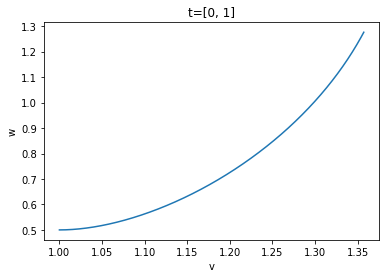

In [2]:
def RK4(f, t, iv):
    """
    Integrate ODE with Runge-Kutta 4 step
    """
    dt = t[1] - t[0]
    u = numpy.zeros((5, t.shape[0]))
    u[:, 0] = iv 
    for n, t_n in enumerate(t[1:]):
        y_1 = u[:, n]
        y_2 = u[:, n] + 0.5 * dt * f(t_n, y_1)
        y_3 = u[:, n] + 0.5 * dt * f(t_n + 0.5 * dt, y_2)
        y_4 = u[:, n] + dt * f(t_n + 0.5 * dt, y_3)
        u[:, n+1] = (u[:, n] + dt / 6 
                        * (f(t_n, y_1) 
                        + 2.0 * f(t_n + 0.5 * dt, y_2)  
                        + 2.0 * f(t_n + 0.5 * dt, y_3) 
                        + f(t_n + dt, y_4)))

    return u


def f(t, u):
    return numpy.array([u[1], 
                        u[2], 
                        u[0] * u[2] * t ** 2 - u[0] * u[4], 
                        u[4], 
                        u[3] * u[4] * t + 4 * u[1]])

t = numpy.linspace(0, 1, 10000)
iv = numpy.array([1, 1/4, 1/3, 1/2, 0])
# Solve with RK4
u = RK4(f, t, iv)
    
plt.plot(u[0], u[3])
plt.xlabel('v')
plt.ylabel('w')
plt.title('t=[0, 1]')

**(c)** (5) For systems of non-linear ODEs it is often useful to consider the linearization of the right-hand-side function $f$ and its properties as approximately linear in some region.  The Jacobian matrix $J(f)$ is often used in this context with
$$
    u' \approx J(f) u = A(t,u) u.
$$
This is useful if attempting to use an implicit method as we can evaluate the Jacobian matrix at the current time so that it is not dependent on $U_{n+1}$ and then solve a linear system of equations.

Compute the Jacobian matrix of $f(t, u)$ for the system from part (a).  Recall that the Jacobian matrix is defined as 
$$
    [J(f(t,u))]_{ij} = \frac{\partial}{\partial u_j}  f_i(t, u).
$$

$$
J(f(t,u)) = \begin{bmatrix}
0 & 1 & 0 & 0 &0 \\
0 & 0 & 1 & 0 &0 \\
u_3 t^2 - u_5 & 0 & u_1 t^2 & 0 & -u_1 \\
0 & 0 & 0 & 0 & 1 \\
0 & 4 & 0 & u_5 t &u_4 t \\
\end{bmatrix}
$$

**(d)** (10) Now using the approach outlined in part (c) use the ODE solver Adams-Moulton 3-step to solve the equations.  This time you may use `numpy.linalg.solve`.  Please plot the results as before.

$$
\begin{align}
U_{n+3} &= U_{n+2} + \frac{\Delta t}{24} (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2}) + 9f(U_{n+3})) \\
U_{n+3} &= U_{n+2} + \frac{\Delta t}{24} (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2}) + 9 J(U_{n+2}) U_{n+3}) \\
U_{n+3} - \frac{9\Delta t}{24} J(U_{n+2}) U_{n+3} &= U_{n+2} + \frac{\Delta t}{24} (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2})) \\
(I_n - \frac{9\Delta t}{24} J(U_{n+2}))U_{n+3} &= U_{n+2} + \frac{\Delta t}{24} (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2})) \\
\end{align}
$$
 
Where I_n is the identity matrix for dimention n (in this case 5)

If we solve this linear system of equations, we will get our next step $U_3$

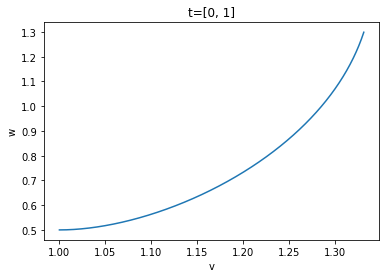

In [3]:
def RK2(f, t, iv):
    """
    Integrate an ODE with RK2
    """
    dt = t[1] - t[0]
    u = numpy.zeros((iv.shape[0], t.shape[0]))
    
    u[:, 0] = iv 
    for n, t_n in enumerate(t[1:]):
        u[:, n+1] = u[:, n] + 0.5 * dt * f(t_n, u[:, n])
        u[:, n+1] = u[:, n] + dt * f(t_n, u[:, n+1])
    return u


def linear_AM3(f, jac, t, iv):
    """
    Integrate using AM3, aproximating
    with the jacobian
    """
    dt = t[1] - t[0]
    u = numpy.zeros((5, t.shape[0]))
    
    # Bootstrap
    u[:, :3] = RK2(f, t[:3], iv)

    
    for n in range(len(t[3:])):
        # Calculate b vector
        b = (u[:, n+2] + (dt/24) * (
            f(t[n], u[:, n]) 
            - 5 * f(t[n+1], u[:, n+1]) 
            + 19 * f(t[n+2], u[:, n+2])))
        A = numpy.identity(5) - (9 * dt / 24) * jac(t[n+2], u[:, n+2])
        # Solve
        u[:, n+3] = numpy.linalg.solve(A, b)  
    return u


def jac(t, u):
    """
    Returns the jacobian for the system
    """
    return numpy.stack([[0, 1, 0, 0, 0], 
                       [0, 0, 1, 0, 0],
                       [u[2] * t**2 - u[4], 0, u[0] * t **2, 0, -u[0]],
                       [0, 0, 0, 0, 1],
                       [0, 4, 0, u[4] * t, u[3] * t]])



def f(t, u):
    return numpy.array([u[1], 
                        u[2], 
                        u[0] * u[2] * t ** 2 - u[0] * u[4], 
                        u[4], 
                        u[3] * u[4] * t + 4 * u[1]])
    
    
t = numpy.linspace(0, 1, 1000)
iv = numpy.array([1, 1/4, 1/3, 1/2, 0])
u = linear_AM3(f, jac, t, iv)

plt.plot(u[0], u[3])
plt.xlabel('v')
plt.ylabel('w')
plt.title('t=[0, 1]')

**(e)** (5) Comment on what you observe from parts (b) and (d).  Try increasing the $t_f$ or changing the number of times steps you take (or shrink $\Delta t$).  Explain why you might see this behavior.

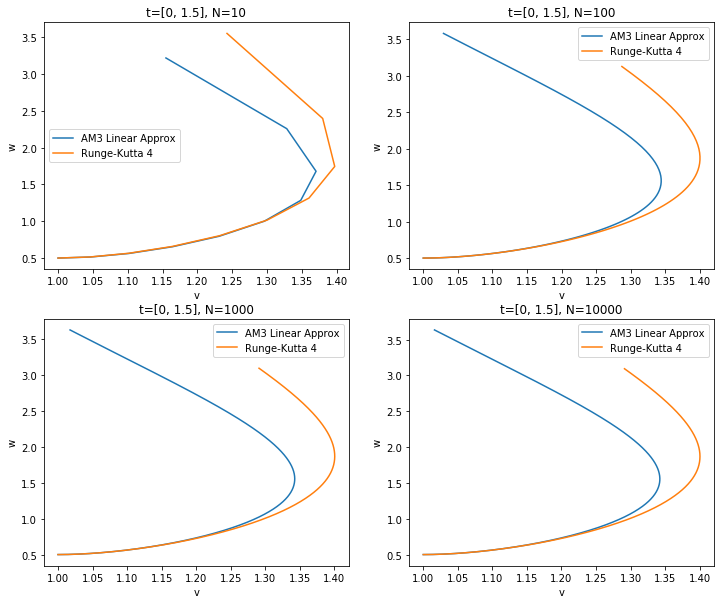

In [4]:
def RK2(f, t, iv):
    """
    Integrate an ODE with RK2
    """
    dt = t[1] - t[0]
    u = numpy.zeros((iv.shape[0], t.shape[0]))
    
    u[:, 0] = iv 
    for n, t_n in enumerate(t[1:]):
        u[:, n+1] = u[:, n] + 0.5 * dt * f(t_n, u[:, n])
        u[:, n+1] = u[:, n] + dt * f(t_n, u[:, n+1])
    return u


def linear_AM3(f, jac, t, iv):
    """
    Integrate using AM3, aproximating
    with the jacobian
    """
    dt = t[1] - t[0]
    u = numpy.zeros((5, t.shape[0]))
    
    # Bootstrap
    u[:, :3] = RK2(f, t[:3], iv)

    
    for n in range(len(t[3:])):
        # Calculate b vector
        b = (u[:, n+2] + (dt/24) * (
            f(t[n], u[:, n]) 
            - 5 * f(t[n+1], u[:, n+1]) 
            + 19 * f(t[n+2], u[:, n+2])))
        A = numpy.identity(5) - (9 * dt / 24) * jac(t[n+2], u[:, n+2])
        # Solve
        u[:, n+3] = numpy.linalg.solve(A, b)  
    return u

def jac(t, u):
    """
    Returns the jacobian for the system
    """
    return numpy.stack([[0, 1, 0, 0, 0], 
                       [0, 0, 1, 0, 0],
                       [u[2] * t**2 - u[4], 0, u[0] * t **2, 0, -u[0]],
                       [0, 0, 0, 0, 1],
                       [0, 4, 0, u[4] * t, u[3] * t]])

def f(t, u):
    return numpy.array([u[1], 
                        u[2], 
                        u[0] * u[2] * t ** 2 - u[0] * u[4], 
                        u[4], 
                        u[3] * u[4] * t + 4 * u[1]])

def RK4(f, t, iv):
    """
    Integrate ODE with Runge-Kutta 4 step
    """
    dt = t[1] - t[0]
    u = numpy.zeros((5, t.shape[0]))
    u[:, 0] = iv 
    for n, t_n in enumerate(t[1:]):
        y_1 = u[:, n]
        y_2 = u[:, n] + 0.5 * dt * f(t_n, y_1)
        y_3 = u[:, n] + 0.5 * dt * f(t_n + 0.5 * dt, y_2)
        y_4 = u[:, n] + dt * f(t_n + 0.5 * dt, y_3)
        u[:, n+1] = (u[:, n] + dt / 6 
                        * (f(t_n, y_1) 
                        + 2.0 * f(t_n + 0.5 * dt, y_2)  
                        + 2.0 * f(t_n + 0.5 * dt, y_3) 
                        + f(t_n + dt, y_4)))

    return u

dt_arr = [10, 100, 1000, 10000]
t_arr = [numpy.linspace(0, 1.5, dt) for dt in dt_arr]
t = numpy.linspace(0, 1.5, 1000)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2.5)
for idx, t in enumerate(t_arr):
    axes = fig.add_subplot(2, 2, idx + 1)
    iv = numpy.array([1, 1/4, 1/3, 1/2, 0])
    u_1 = linear_AM3(f, jac, t, iv)
    u_2 = RK4(f, t, iv)

    axes.plot(u_1[0], u_1[3], label='AM3 Linear Approx')
    axes.plot(u_2[0], u_2[3], label='Runge-Kutta 4')
    axes.set_xlabel('v')
    axes.set_ylabel('w')
    axes.legend()
    axes.set_title('t=[0, 1.5], N=' + str(dt_arr[idx]))

From $t=0$ to $t=1$ the system curves upwards, and both of the approxmations are nearly identical. However, once the curve starts doubling back on itself, the two approximations begin to differ with w being tracked pretty well, while v differing wildly between the two approximations. This could be because linear approximation breaks down and the error becomes additive with the higher order derivatives in the v term. Increasing the number of steps makes the curve less piecewise linear, which makes sense as we are integrating at more points.

## Question 2

The Poincaré-Bendixson theorem describes the behavior of two-dimensional ODE systems that under certain conditions a system will exhibit either a stable equilibrium point or contains a limit cycle (such as we see in an oscillator).

**Poincaré-Bendixson Theorem:**  The attractor for any smooth two-dimensional bounded continuous-time autonomous system is either a stable equilibrium or a limit cycle.

Now consider the system
$$\begin{aligned}
    \frac{dx}{dt} &= \frac{xy}{x^2 + y^2} - \alpha x, \\
    \frac{dy}{dt} &= \frac{y^2}{x^2 + y^2} - \beta y + \beta -1 
\end{aligned}$$
with $\alpha, \beta \in \mathbb{R}$.  

**(a)** (5) What point may be problematic for us and violate the Poincaré-Bendixson theorem?

Any fixed point will be problematic for us and violate the theorem. Thus point $(x(t), y(t)) = (1, 0)$ will be problematic because 

$$
x' = \frac{(0)(1)}{1} - \alpha(0) = 0 \\
y' = 1 - \beta + \beta - 1 = 0
$$

Thus $(1, 0)$ is a fixed point and violate the Poincare-Bendixson Theorem. This is because even though it is an equillibrium, any push will cause the limit cycle to start again or the point to fall into stable equlibrium, so it is not stable.

**(b)**  (5) Formulate the system 
$\frac{d}{dt}\mathbf{u} = f(t, \mathbf{u})$ where $\mathbf{u} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} $

$$
u= \begin{bmatrix} x \\ y  \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} 
$$

$$
\frac{d}{dt}\begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = 
\begin{bmatrix}
\frac{u_1 u_2}{u_1^2 + u_2^2} - \alpha u_1 \\
\frac{u_2^2}{u_1^2 + u_2^2} - \beta u_2 + \beta - 1
\end{bmatrix}
$$

**(c)** (15) Solve the above system numerically using a predictor-corrector method with the 3-step Adams-Bashforth as the predictor and the 3-step Adams-Moulton method as the corrector.  Use RK2 to boot-strap (start) the method.  Use the initial condition
$$
    (x_0, y_0) = (1, 0)
$$
and
$$
    \alpha = 0 ~~~ \text{and} ~~~ \beta = 0.7.
$$
Plot the phase-plane solution ($x$ vs. $y$) for $t_f$ at least out to $t = 100$.  Comment on what you see making sure to connect it to the Poincaré-Bendixson theorem.  You also may want to play with the initial condition and shorter time spans to examine the behavior around a particular point.

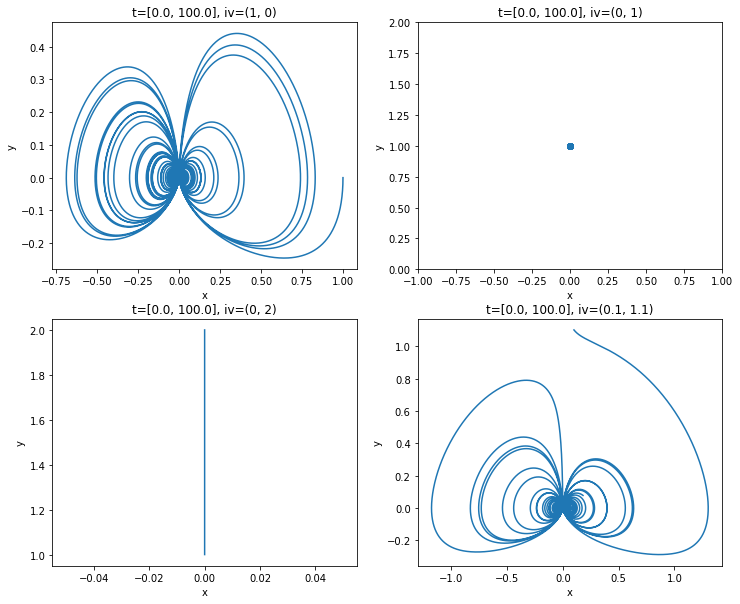

In [5]:
def RK2(f, t, iv):
    """
    Integrate an ODE with RK2
    """
    dt = t[1] - t[0]
    u = numpy.zeros((iv.shape[0], t.shape[0]))
    
    u[:, 0] = iv 
    for n, t_n in enumerate(t[1:]):
        u[:, n+1] = u[:, n] + 0.5 * dt * f(t_n, u[:, n])
        u[:, n+1] = u[:, n] + dt * f(t_n, u[:, n+1])
    return u


def pred_correct(f, t, iv):
    """
    Integrate an ode with specified t values and initial
    values using predictor corrector with 3-step AB
    and 3-step AM. Use RK2 bootstrap to start the method
    
    """
    dt = t[1] - t[0]
    u = numpy.zeros((iv.shape[0], t.shape[0]))
    u[:, :3] = RK2(f, t[:3], iv)

    for n in range(len(t[3:])):
        # Adams-Bashforth predictor
        u_hat = (u[:, n+2]
                + (dt / 12) * (5 * f(t[n], u[:, n])
                               - 16 * f(t[n+1], u[:, n+1])
                               + 23 * f(t[n+2], u[:, n+2])))

        # Adams-Moulton corrector
        u[:, n+3] = (u[:, n+2]
                    + (dt / 24) * (f(t[n], u[:, n])
                                   - 5 * f(t[n+1], u[:, n+1])
                                   + 19 * f(t[n+2], u[:, n+2])
                                   + 9 * f(t[n+3], u_hat)))
    return u

def plot_system(axes, f, t, iv, scatter=False):
    """
    Plot the system f for some initial condition and
    time series on specified axes
    
    """
    u = pred_correct(f, t, iv)
    if scatter:
        axes.scatter(u[0, :], u[1, :])
    else:
        axes.plot(u[0, :], u[1, :])
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.set_title('t=[' + str(t[0]) + ', ' + str(t[-1])
              + '], iv=(' + str(iv[0]) +', ' + str(iv[1]) +')')

# Define system
alpha = 0
beta = 0.7
def f(t, u):
    den = u[0] ** 2 + u[1] ** 2
    return numpy.array(
        [(u[0] * u[1]) / den - alpha * u[0], 
         u[1] ** 2 / den - beta * u[1] + beta - 1]) 
    
# Plot
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2.5)

axes = fig.add_subplot(2, 2, 1)
t = numpy.linspace(0, 100, 10000)
iv = numpy.array([1, 0])
plot_system(axes, f, t, iv)

axes = fig.add_subplot(2, 2, 2)
t = numpy.linspace(0, 100, 10000)
iv = numpy.array([0, 1])
plot_system(axes, f, t, iv, scatter=True)
# Set lims for better viewing
axes.set_xlim(-1, 1)
axes.set_ylim(0, 2)

axes = fig.add_subplot(2, 2, 3)
t = numpy.linspace(0, 100, 100000)
iv = numpy.array([0, 2])
plot_system(axes, f, t, iv)

axes = fig.add_subplot(2, 2, 4)
t = numpy.linspace(0, 100, 10000)
iv = numpy.array([0.1, 1.1])
plot_system(axes, f, t, iv)

On these plots we change the initial value around to get different behaviors predicted by the Poincare-Bendixson Theorem. On the LHS, we see that the system can either be in a stable equilibrium if $x=0$, or a limit cycle if $x \neq 0$. The RHS demonstrates the violation of the principle by taking the fixed point $(0,1)$ and preturbing it slightly. We see that it is will either fall out of equilibrium. Thus it is unstable and violates the Poincare-Bendixson theorem. 

## Question 3 - Orbits

Newton's equations for the motion of a particle (he sure gets around doesn't he) in planar orbit with eccentricity $e$ where $0 < e < 1$ are

$$\begin{aligned}
    x''(t) &= -\frac{x}{r^3}, ~~~~ &x(0) &= 1 - e, ~~~~ &x'(0) &= 0, \\
    y''(t) &= -\frac{y}{r^3}, ~~~~ &y(0) &= 0, ~~~~ &y'(0) &= \sqrt{\frac{1 + e}{1 - e}}
\end{aligned}$$

with $r^2 = x^2 + y^2.$

**(a)** (5) Reformulate the problem as an initial value problem for a system of first-order differential equations.

$$
u= \begin{bmatrix} x \\ x' \\ y \\ y' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \\u_3 \\u_4 \end{bmatrix} 
$$

$$
\frac{d}{dt}\begin{bmatrix} u_1 \\ u_2 \\ u_3 \\ u_4\end{bmatrix} = 
\begin{bmatrix}
u_2 \\
-\frac{u_1}{r^3}\\
u_4\\
-\frac{u_3}{r^3}
\end{bmatrix}
$$

$$
u(0) = \begin{bmatrix} 1 - e\\ 0 \\ 0 \\\sqrt{\frac{1+e}{1-e}} \end{bmatrix}
$$

Where 
$$
r^2 = u_1^2 + u_3^2
$$

**(b)** (5) Write a function that computes the solution to the IVP from (b) given a provided set of time steps and eccentricity $e$ using a 2nd order Runge-Kutta method.  The function should only return the values of $x$ and $y$.

In [4]:
def RK2(f, t, iv):
    """
    Integrate an ODE with RK2
    """
    dt = t[1] - t[0]
    u = numpy.zeros((iv.shape[0], t.shape[0]))
    
    u[:, 0] = iv 
    for n, t_n in enumerate(t[1:]):
        u[:, n+1] = u[:, n] + 0.5 * dt * f(t_n, u[:, n])
        u[:, n+1] = u[:, n] + dt * f(t_n, u[:, n+1])
    return u
        

def solve_orbit_RK2(t, e):
    """
    Solve an orbit with eccentricity e using RK2
    """
    def f(t, u):
        r = numpy.sqrt(u[0] ** 2 + u[2] ** 2)
        return numpy.array([u[1], -u[0] / (r ** 3), u[3], -u[2] / (r ** 3)])

    iv = numpy.array([1 - e, 0, 0, numpy.sqrt((1 + e) / (1 - e))])
    u = RK2(f, t, iv)

    x = u[0]
    y = u[2]
    return x, y

In [5]:
# Testing to make sure that the solution remains bounded in the testing interval
x, y = solve_orbit_RK2(numpy.linspace(0.0, 10.0, 1000), 0.9)
assert(numpy.all(numpy.abs(x) < 10.0))
assert(numpy.all(numpy.abs(y) < 10.0))
print("Solutions remained bounded for testing interval.")

Solutions remained bounded for testing interval.


**(c)** (3) Plot the trajectory of the orbiting particle parametrically given $e = 0.9$ and times between $t = [0, 100]$.

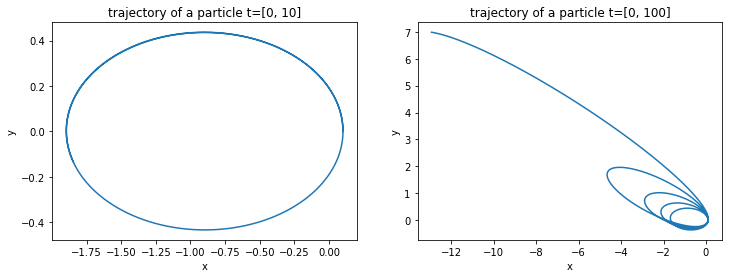

In [12]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight())

t = numpy.linspace(0.0, 10, 10000)
e = 0.9
x, y = solve_orbit_RK2(t, e)
axes1 = fig.add_subplot(1, 2, 1)
axes1.plot(x, y)
axes1.set_title('trajectory of a particle t=[0, 10]')
axes1.set_xlabel('x')
axes1.set_ylabel('y')

t = numpy.linspace(0.0, 100, 10000)
e = 0.9
x, y = solve_orbit_RK2(t, e)
axes2 = fig.add_subplot(1, 2, 2)
axes2.plot(x, y)
axes2.set_title('trajectory of a particle t=[0, 100]')
axes2.set_xlabel('x')
axes2.set_ylabel('y')

## Question 4 - Absolute Stability Regions and Order Stars

**(a)** (10) Plot the regions of absolute stability for the following:
1. Taylor Series methods of order 2 to 5,
1. 3-step and 4-step Adams-Basforth methods, and
1. 3-step and 4-step Adams-Moulton methods.

For the Taylor series methods also determine the interior and exterior of the stability regions.


##### Taylor Series methods
We have general region $R(z) = 1 + z + \frac{1}{2}z^2 + \dots +\frac{1}{p!}z^p$

##### Adams-Basforth

3-step
$$
\begin{align}
U_{n+3} &= U_{n+2} + \frac{\Delta t}{12}(5f(U_n) - 15 f(U_{n+1}) + 23 f(U_{n+2})) \\
U_{n+3} - U_{n+2} &= \frac{\Delta t}{12}(5f(U_n) - 15 f(U_{n+1}) + 23 f(U_{n+2}))\\
U_{n+3} - U_{n+2} &= \frac{1}{12}(5 \Delta t\lambda U_n - 15 \Delta t \lambda U_{n+1} + 23 \Delta t \lambda U_{n+2}) \\
12(U_{n+3} - U_{n+2}) &= 5 \Delta t\lambda U_n - 15 \Delta t \lambda U_{n+1} + 23 \Delta t \lambda U_{n+2} \\
12(U_{n+3} - U_{n+2}) &= 5 z U_n - 15 z U_{n+1} + 23 z U_{n+2} \\
12(U_{n+3} - U_{n+2}) &= z(5 U_n - 15 U_{n+1} + 23 U_{n+2}) \\
12(\xi - 1) \xi^2 &= z(5 - 15 \xi + 23 \xi^2) \\
p(\xi, z) &= z\sigma(\xi, z)
\end{align}
$$

where $p(\xi, z) = 12(\xi - 1) \xi^2$ and $\sigma = 23\xi^2 - 15\xi + 5$

4-step
$$
\begin{align}
U_{n+4} &= U_{n+3} + \frac{\Delta t}{24}(-9f(U_n) + 37 f(U_{n+1}) - 59 f(U_{n+2}) + 55 f(U_{n+3}) \\
U_{n+4} -  U_{n+3} &= \frac{\Delta t}{24}(-9f(U_n) + 37 f(U_{n+1}) - 59 f(U_{n+2}) + 55 f(U_{n+3})\\
24(U_{n+4} -  U_{n+3}) &= (-9 \Delta t \lambda U_n + 37 \Delta t \lambda U_{n+1} - 59 \Delta t \lambda U_{n+2} + 55 \Delta t \lambda U_{n+3}) \\
24(U_{n+4} -  U_{n+3}) &= (-9 z U_n + 37 z U_{n+1} - 59 z U_{n+2} + 55z U_{n+3}) \\
24(U_{n+4} -  U_{n+3}) &= z(-9U_n + 37 U_{n+1} - 59 U_{n+2} + 55U_{n+3}) \\
24(\xi - 1) \xi^3 &= z(-9 + 37\xi - 59 \xi^2 + 55\xi^3) \\
p(\xi, z) &= z\sigma(\xi, z)
\end{align}
$$

where $p(\xi, z) = 24(\xi - 1)\xi^3$ and $\sigma(\xi, z) = 55\xi^3 - 59\xi^2 + 37\xi - 9$


##### Adams-Moulton

3-step
$$
\begin{align}
U_{n+3} &= U_{n+2} + \frac{\Delta t}{24}(f(U_n) - 5 f(U_{n+1}) + 19 f(U_{n+2}) + 9f(U_{n+3}) \\
U_{n+3} - U_{n+2} &= \frac{\Delta t}{24}(f(U_n) - 5 f(U_{n+1}) + 19 f(U_{n+2}) + 9f(U_{n+3}) \\
24(U_{n+3} - U_{n+2}) &= \Delta t \lambda U_n - 5\Delta t \lambda U_{n+1} + 19\Delta t \lambda U_{n+2} + 9 \Delta t \lambda U_{n+3} \\
24(U_{n+3} - U_{n+2}) &= z U_n - 5z U_{n+1} + 19z U_{n+2} + 9 z U_{n+3} \\
24(\xi - 1)\xi^2 &= z (1 - 5\xi + 19\xi^2 + 9 \xi^3) \\
p(\xi, z) &= z\sigma(\xi, z)
\end{align}
$$

where $p(\xi, z) = 24(\xi - 1)\xi^2$ and $\sigma(\xi, z) = 9 \xi^3 + 19 \xi^2 - 5 \xi + 1$

4-step
$$
\begin{align}
U_{n+4} &= U_{n+3} + \frac{\Delta t}{720}(-19f(U_n) - 106 f(U_{n+1}) + 19-264f(U_{n+2}) + 646f(U_{n+3}) + 251f(U_{n+4})) \\
U_{n+4} - U_{n+3} &= \frac{\Delta t}{720}(-19f(U_n) - 106 f(U_{n+1}) -264f(U_{n+2}) + 646f(U_{n+3}) + 251f(U_{n+4})) \\
720(U_{n+4} - U_{n+3}) &= (-19 \Delta t \lambda U_n - 106 \Delta t \lambda U_{n+1} - 264 \Delta t \lambda U_{n+2} + 646 \Delta t \lambda U_{n+3} + 251 \Delta t \lambda U_{n+4}) \\
720(U_{n+4} - U_{n+3}) &= z(-19 U_n - 106 U_{n+1} - 264 U_{n+2} + 646 U_{n+3} + 251 U_{n+4}) \\
720(\xi - 1)\xi^3 &= z(-19 - 106 \xi - 264 \xi^2 + 646 \xi^3 + 251 \xi^4) \\
p(\xi, z) &= z\sigma(\xi, z)
\end{align}
$$

where $p(\xi, z) = 720(\xi - 1)\xi^3$ and $\sigma(\xi, z) = 251 \xi^4 + 646 \xi^3 - 264 \xi^2 + 106 \xi - 19$

Taylor Series method of order 2 - Stability of region tests
  Inside of region:  0.5
  Outside of region:  5.0
Taylor Series method of order 3 - Stability of region tests
  Inside of region:  0.333333333333
  Outside of region:  5.66666666667
Taylor Series method of order 4 - Stability of region tests
  Inside of region:  0.375
  Outside of region:  5.0
Taylor Series method of order 5 - Stability of region tests
  Inside of region:  0.366666666667
  Outside of region:  3.53333333333


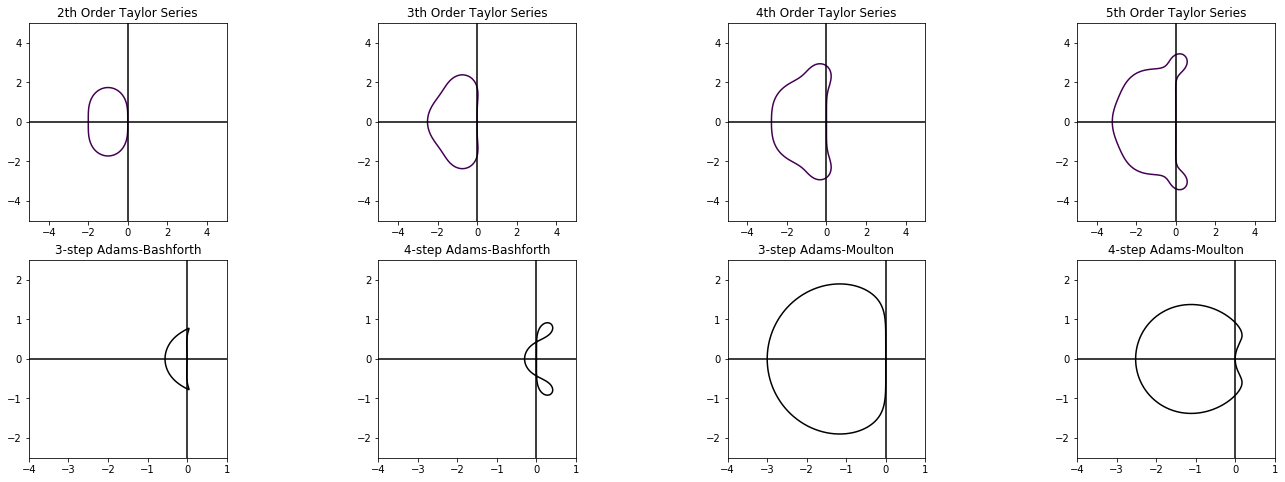

In [9]:
def plot_taylor_stability(axes, f):
    """
    Plot the taylor stability level
    curve |f(x)| = 1 on the specified axis
    """
    x = numpy.linspace(-5, 5, 100)
    y = numpy.linspace(-5, 5, 100)

    X, Y = numpy.meshgrid(x, y)
    Z = X + 1j * Y

    axes.contour(X, Y, numpy.abs(f(Z)), levels=[1.0])
    axes.plot(x, numpy.zeros(x.shape),'k')
    axes.plot(numpy.zeros(y.shape), y,'k')
    axes.set_aspect('equal')

    
def print_taylor_stability_test(outside, inside, order, f):
    """
    Print out test of stability given a point inside 
    and outside of the taylor series curve. 
    The interior of the stablity region is the point
    where |f(p)| < 1
    
    Parameters
    ----------
    outside: complex number
        The complex number inside of the curve
    inside: complex number
        The complex number outside of the curve
        
    """
    # Evaluate which regions are actually in stability region
    print('Taylor Series method of order ' + str(order)
                          + ' - Stability of region tests')
    print("  Inside of region: ", numpy.abs(f(inside)))
    print("  Outside of region: ", numpy.abs(f(outside)))
  

def plot_adams_stability(axes, rho, sigma):
    """
    Plot stability regions of the adams-basforth
    and adams-moulton methods given
    a rho and sigma polynomial 
    """
    x = numpy.linspace(-5, 5, 100)
    y = numpy.linspace(-5, 5, 100) 
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, 1000)
    xi = numpy.exp(1j * theta)
    z = rho(xi) / sigma(xi)

    axes.plot(z.real, z.imag, 'k')
    axes.plot(x, numpy.zeros(x.shape),'k')
    axes.plot(numpy.zeros(y.shape), y,'k')
    axes.set_aspect('equal')
    axes.set_xlim([-4, 1])
    axes.set_ylim([-2.5, 2.5])
    
# Configure plot
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 2)


# Taylor 2nd order
axes = fig.add_subplot(2, 4, 1)
f = lambda Z: 1 + Z + (1/2) * Z**2
plot_taylor_stability(axes, f)
print_taylor_stability_test(-4 + 1j * 0, -1 + 1j * 0, 2, f)
axes.set_title("2th Order Taylor Series")


# Taylor 3nd order
axes = fig.add_subplot(2, 4, 2)
f = lambda Z: 1 + Z + (1/2) * Z**2 + (1/6) * Z**3
plot_taylor_stability(axes, f)
print_taylor_stability_test(-4 + 1j * 0, -1 + 1j * 0, 3, f)
axes.set_title("3th Order Taylor Series")


# Taylor 4nd order
axes = fig.add_subplot(2, 4, 3)
f = lambda Z: (1 + Z + (1/2) * Z**2 + (1/6) * Z**3
                        + (1/24)* Z**4)
plot_taylor_stability(axes, f)
print_taylor_stability_test(-4 + 1j * 0, -1 + 1j * 0, 4, f)
axes.set_title("4th Order Taylor Series")


# Taylor 5th order 
axes = fig.add_subplot(2, 4, 4)
f = lambda Z: (1 + Z + (1/2) * Z**2 + (1/6) * Z**3
                        + (1/24)* Z**4 + (1/120) * Z**5)
plot_taylor_stability(axes, f)
print_taylor_stability_test(-4 + 1j * 0, -1 + 1j * 0, 5, f)
axes.set_title("5th Order Taylor Series")


# 3-step Adams-Bashforth
axes = fig.add_subplot(2, 4, 5)
rho = lambda xi: 12 * (xi - 1) * xi**2
sigma = lambda xi: 23 * xi**2 - 15 * xi + 5
plot_adams_stability(axes, rho, sigma)
axes.set_title("3-step Adams-Bashforth")


# 4-step Adams-Bashforth
axes = fig.add_subplot(2, 4, 6)
rho = lambda xi: 24 * (xi - 1) * xi **3
sigma = lambda xi: 55 * xi ** 3 - 59 * xi **2 + 37 * xi - 9
plot_adams_stability(axes, rho, sigma)
axes.set_title("4-step Adams-Bashforth")


# 3-step Adams-Moulton
axes = fig.add_subplot(2, 4, 7)
rho = lambda xi: 24 * (xi - 1) * xi ** 2
sigma = lambda xi: 9 * xi ** 3 + 19 * xi **2 - 5 * xi + 1
plot_adams_stability(axes, rho, sigma)
axes.set_title("3-step Adams-Moulton")


# 4-step Adams-Moulton
axes = fig.add_subplot(2, 4, 8)
rho = lambda xi: 720 * (xi - 1) * xi ** 3
sigma = lambda xi: (251 * xi **4 + 646 * xi **3 -
                    264 * xi**2 - 106 * xi -19)
plot_adams_stability(axes, rho, sigma)
axes.set_title("4-step Adams-Moulton")

For our stability tests for the taylor series, we see that the regions always include the point $-1 + 0i$ and don't include $-4 + 0i$, so we use those two points to see that the stability is in the curve interior.

**(b)** (10) The region of absolute stability as defined ensures that the error does not grow in subsequent time-steps hence why we require $|R(z)| < 1$.  In reality what we really want is that the errors decay faster than the solution or that it grows slower than the true solution.  Consider the solution of an ODE $u(t) = e^{\lambda t}$, if $\lambda < 0$ then we want our errors made at each time step $E^n$ to decay faster than $e^{\lambda t}$ so that $|E^n| < e^{\lambda t}$.  Conversely if $\lambda > 0$ then we might also want $|E^n| < e^{\lambda t}$.  This suggests a new definition of stability, called the **relative stability** defined as

$$|R(z)| \leq |e^z|.$$

These turn out to be difficult to plot but proved pivotal due to work in 1978 by Wanner, Hairer and Nørset.  More recently a new set of regions, called **order stars**, have become more popular to consider.  These are defined as the three regions

$$\begin{aligned}
    \mathcal{A}_{-} &= \{ z \in \mathbb{C}: |R(z)| < |e^z| \} = \{z \in \mathbb{C}: |e^{-z} R(z)| < 1\}, \\ 
    \mathcal{A}_{0} &= \{ z \in \mathbb{C}: |R(z)| = |e^z| \} = \{z \in \mathbb{C}: |e^{-z} R(z)| = 1\}, ~~~~\text{and} \\
    \mathcal{A}_{+} &= \{ z \in \mathbb{C}: |R(z)| > |e^z| \} = \{z \in \mathbb{C}: |e^{-z} R(z)| > 1\}.
\end{aligned}$$

Plot the region $\mathcal{A}_{0}$ for the Taylor series methods asked for in part (a).  Do you see any relation to the number of "fingers" and the order of the method?

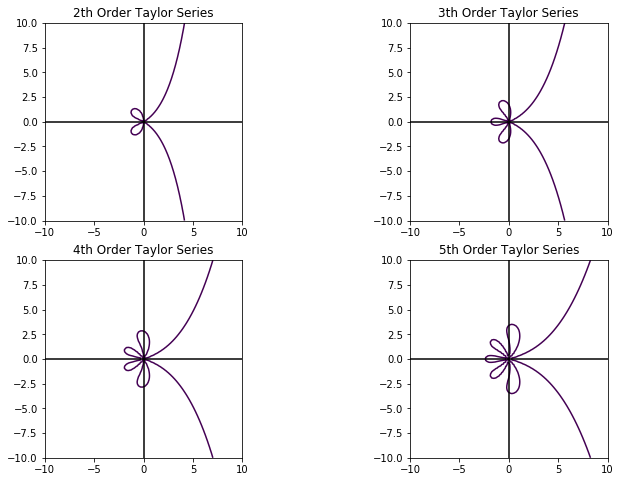

In [10]:
def plot_taylor_A0(axes, f):
    """
    Plot the A_0 order star for given 
    taylor series stability polynomial
    """
    x = numpy.linspace(-10, 10, 100)
    y = numpy.linspace(-10, 10, 100)

    X, Y = numpy.meshgrid(x, y)
    Z = X + 1j * Y

    axes.contour(X, Y, numpy.abs(
        numpy.exp(-Z) * f(Z)), levels=[1.0])
    axes.plot(x, numpy.zeros(x.shape),'k')
    axes.plot(numpy.zeros(y.shape), y,'k')
    axes.set_aspect('equal')

# Configure plot
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)

# Taylor 2nd order
axes = fig.add_subplot(2, 2, 1)
f = lambda Z: 1 + Z + (1/2) * Z**2
plot_taylor_A0(axes, f)
axes.set_title("2th Order Taylor Series")


# Taylor 3nd order
axes = fig.add_subplot(2, 2, 2)
f = lambda Z: 1 + Z + (1/2) * Z**2 + (1/6) * Z**3
plot_taylor_A0(axes, f)
axes.set_title("3th Order Taylor Series")


# Taylor 4nd order
axes = fig.add_subplot(2, 2, 3)
f = lambda Z: (1 + Z + (1/2) * Z**2 + (1/6) * Z**3 
                        + (1/24)* Z**4)
plot_taylor_A0(axes, f)
axes.set_title("4th Order Taylor Series")


# Taylor 5th order 
axes = fig.add_subplot(2, 2, 4)
f = lambda Z: (1 + Z + (1/2) * Z**2 + (1/6) * Z**3 
                        + (1/24)* Z**4 + (1/120) * Z**5)
plot_taylor_A0(axes, f)
axes.set_title("5th Order Taylor Series")

It's clear to see that the number of fingers is equal to the order of the method.

## Question 5 - SciPy Integrate

Consider the decay process
$$
    A \overset{K_1}{\rightarrow} B \overset{K_2}{\rightarrow} C \overset{K_3}{\rightarrow} D
$$
represented by the system of ODEs
\begin{align*}
    \frac{\text{d}A}{\text{d}t} &= -K_1 A \\
    \frac{\text{d}B}{\text{d}t} &= K_1 A - K_2 B \\
    \frac{\text{d}C}{\text{d}t} &= K_2 B - K_3 C \\
    \frac{\text{d}D}{\text{d}t} &= K_3 C \\
\end{align*}

**(a)** Write a function that uses `scipy.integrate` to compute the solution to the system of ODEs given an initial condition and time points to output at.  This function should take in the time points for the output, an initial condition, the ODE integrator to use (default to "dopri5"), and the reaction rates $K_1$, $K_2$, and $K_3$.

In [11]:
import scipy.integrate as integrate

def solve_decay_system(t, u_0, solver_type="dopri5", K_1=0.0, K_2=0.0, K_3=0.0):
    """
    Solve the given decay system with
    scipy.integrate. Use given parameters and 
    solver for the solution.
    
    """
    f = lambda t, u: numpy.array(
        [-K_1 * u[0], 
         K_1 * u[0] - K_2 * u[1], 
         K_2 * u[1] - K_3 * u[2], 
         K_3 * u[2]])
    
    u = numpy.zeros((u_0.shape[0], t.shape[0]))
    u[:, 0] = u_0
    integrator = integrate.ode(f)
    integrator.set_integrator(solver_type)
    integrator.set_initial_value(u[:, 0])
    
    for n, t_n in enumerate(t[1:]):
        integrator.integrate(t_n)
        if not integrator.successful():
            break
        u[:, n + 1] = integrator.y
    return u.T


In [12]:
t = numpy.linspace(0.0, 10.0, 10)
u_0 = numpy.array([1.0, 0.0, 0.0, 0.0])
U = solve_decay_system(t, u_0, solver_type='dopri5', K_1=1.0, K_2=2.0, K_3=3.0)
U_sol = numpy.array([[1.0000000000000000e+00, 0.0000000000000000e+00,
                      0.0000000000000000e+00, 0.0000000000000000e+00],
                     [3.2919298826277271e-01, 2.2082495381343401e-01,
                      1.4813096181267352e-01, 3.0185109611111993e-01],
                     [1.0836802654276900e-01, 9.6624368667878130e-02,
                      8.6153390524786266e-02, 7.0885421426456674e-01],
                     [3.5673996630001523e-02, 3.4401353001617396e-02,
                      3.3174114479337484e-02, 8.9675053588904374e-01],
                     [1.1743631968628626e-02, 1.1605715517361529e-02,
                      1.1469419325266718e-02, 9.6518123318874338e-01],
                     [3.8659219913406520e-03, 3.8509760174843801e-03,
                      3.8360878593115726e-03, 9.8844701413186375e-01],
                     [1.2726346009991362e-03, 1.2710149139283067e-03,
                      1.2693972897971615e-03, 9.9618695319527573e-01],
                     [4.1894244902209761e-04, 4.1876692442412833e-04,
                      4.1859147343448249e-04, 9.9874369915311978e-01],
                     [1.3791293652887476e-04, 1.3789391503107924e-04,
                      1.3787489615970831e-04, 9.9958631825228084e-01],
                     [4.5399978275093905e-05, 4.5397916926305302e-05,
                      4.5395855671230534e-05, 9.9986380624912774e-01]])
numpy.testing.assert_allclose(U, U_sol)
print("Success!")

Success!


**(b)** Plot your solution given the input data provided above and again using the `dopri5` integrator but increase the number of output times so you can plot a smooth solution.  Do not forget to provide the appropriate labels.

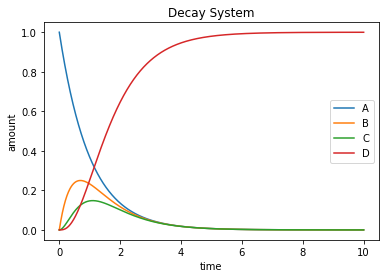

In [13]:
t = numpy.linspace(0.0, 10.0, 1000)
u_0 = numpy.array([1.0, 0.0, 0.0, 0.0])
U = solve_decay_system(t, u_0, solver_type='dopri5',
                       K_1=1.0, K_2=2.0, K_3=3.0)

plt.title('Decay System')
plt.xlabel('time')
plt.ylabel('amount')
plt.plot(t, U[:, 0], label='A')
plt.plot(t, U[:, 1], label='B')
plt.plot(t, U[:, 2], label='C')
plt.plot(t, U[:, 3], label='D')
plt.legend()